# ML model creation and evaluation

This notebook is used to create the following ML-models/mappings for all four test cases:

- rise velocity: $\hat{U}_b(\tilde{t})$
- radius: $\hat{r}(\tilde{t},\vartheta)$
- tangential interface velocity: $\hat{u}_t(\tilde{t},\vartheta)$

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch as pt
from matplotlib import rc
from tqdm import tqdm
from helper_module import SimpleMLP, training_loop
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
rc('text', usetex=True)

cases = ["CB{:1d}".format(i) for i in range(1, 5)]
print("Case names : ", cases)

output_path = "../output/"

# make torch results reproducible and use double precision
pt.set_default_tensor_type(pt.DoubleTensor)
pt.manual_seed(42)
np.random.seed(42)

Case names :  ['CB1', 'CB2', 'CB3', 'CB4']


## Rise velocity

In [2]:
log_files = {}
for case in cases:
    log_path = output_path + case + "/log_file.pkl"
    log_files[case] = pd.read_pickle(log_path)    

In [3]:
model_dict_rv = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 2,
    "n_neurons" : 40,
    "activation" : pt.nn.functional.selu,
    "batch_norm" : False
}

scalers_rv = {}
scaled_data_rv = {}

for case in cases:
    scaler = MinMaxScaler()
    data = scaler.fit_transform(log_files[case][["t", "ub_x"]].values)
    scalers_rv[case] = deepcopy(scaler)
    scaled_data_rv[case] = deepcopy(data)

In [4]:
all_losses = {}

mask = np.zeros((log_files["CB1"].shape[0]), dtype=bool)
mask[:20] = True
mask[20:1000:10] = True
mask[1000::100] = True

epochs = 5000
for case in cases:
    model = SimpleMLP(**model_dict_rv)
    model_path = output_path + "/rise_vel_{:s}.pt".format(case)
    time = scaled_data_rv[case][mask, 0]
    rv = scaled_data_rv[case][mask, 1]
    _, losses = training_loop(model, model_path, time, rv, epochs, 0.001)
    all_losses[case] = losses

100%|██████████| 5000/5000 [00:15<00:00, 323.68it/s]


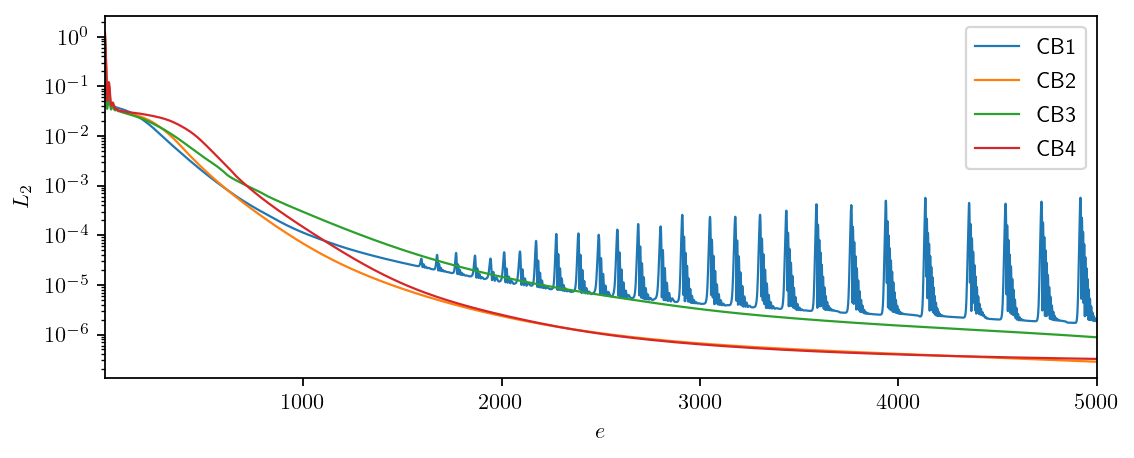

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for i, key in enumerate(all_losses.keys()):
    ax.plot(range(1, epochs+1), all_losses[key], ls="-", lw=1, label=key)
    
ax.set_xlabel("$e$")
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$")
ax.set_yscale('log')
ax.legend()
plt.show()

In [23]:
class RiseVelocityModel(pt.nn.Module):
    def __init__(self, model_dict, model_path, scaler_rv):
        super(RiseVelocityModel, self).__init__()
        self._model = SimpleMLP(**model_dict)
        self._model.load_state_dict(pt.load(model_path))
        self._min_t = pt.tensor(scaler_rv.data_min_[0], dtype=pt.float64)
        self._range_t = pt.tensor(scaler_rv.data_range_[0], dtype=pt.float64)
        self._min_rv = pt.tensor(scaler_rv.data_min_[1], dtype=pt.float64)
        self._range_rv = pt.tensor(scaler_rv.data_range_[1], dtype=pt.float64)
        
    def _scale(self, X):
        return (X - self._min_t) / self._range_t
    
    def _inverse_scale(self, y):
        return y * self._range_rv + self._min_rv
    
    def forward(self, X):
        X = self._scale(X)
        return self._inverse_scale(self._model(X))

Text(0.5, 0, '$t$')

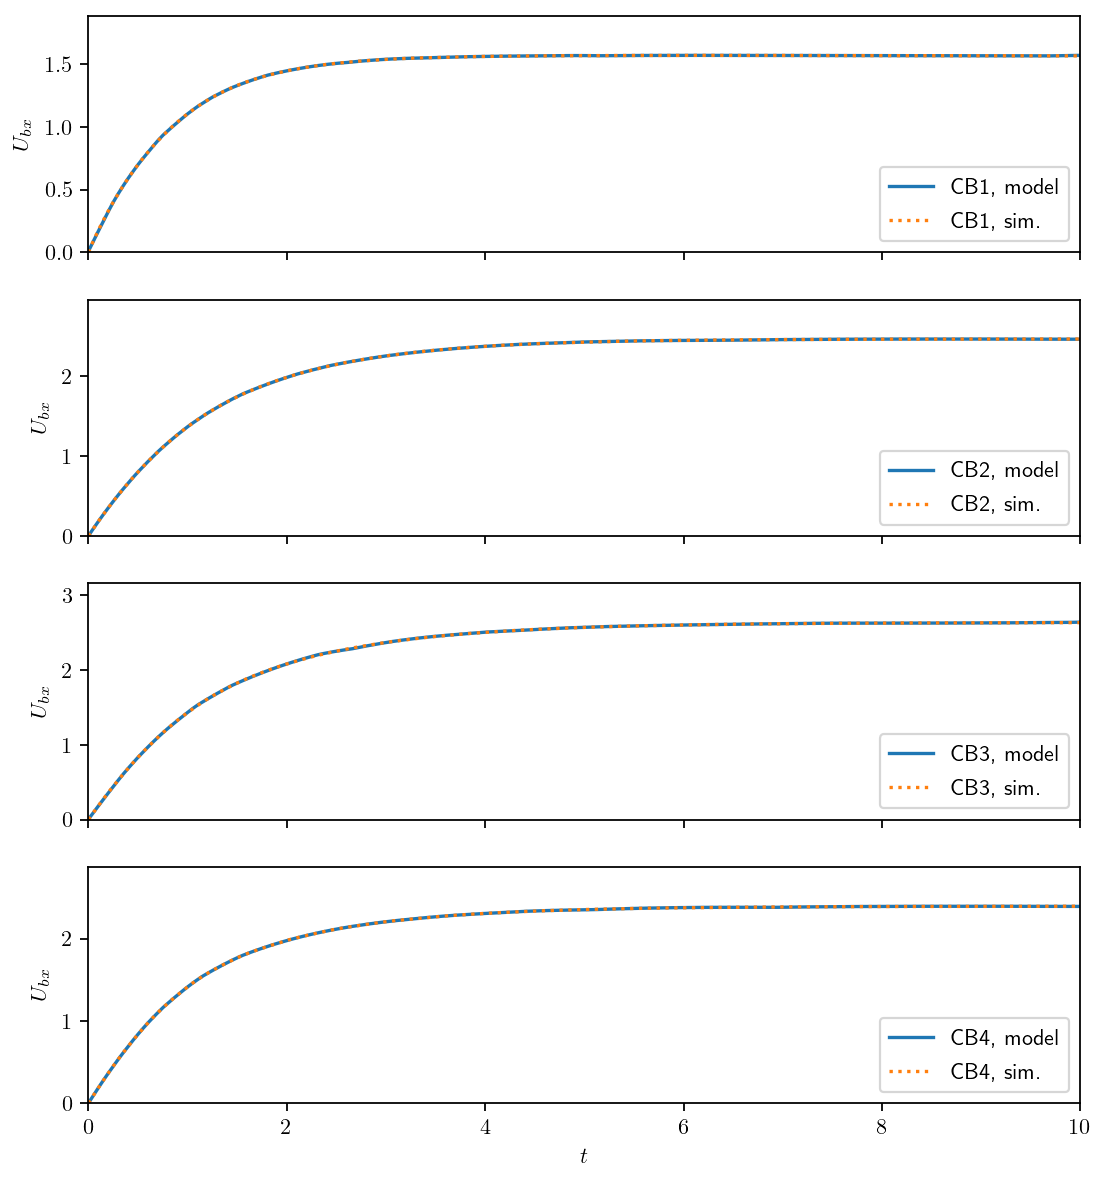

In [7]:
fig, axarr = plt.subplots(len(cases), 1, figsize=(8, 9), sharex=True)
time_plot = pt.linspace(0.0, 10.0, 200, dtype=pt.float64)

for i, case in enumerate(cases):
    model_path = output_path + "/rise_vel_{:s}.pt".format(case)
    model = RiseVelocityModel(model_dict_rv, model_path, scalers_rv[case])
    ub_model = model(time_plot.unsqueeze(-1)).detach().squeeze().numpy()
    axarr[i].plot(time_plot, ub_model, ls="-", label="{:s}, model".format(case))
    axarr[i].plot(log_files[case].t.values, log_files[case].ub_x.values, ls=":", label="{:s}, sim.".format(case))
    axarr[i].set_xlim(0, 10)
    axarr[i].set_ylim(0, 1.2*np.max(log_files[case].ub_x.values))
    axarr[i].set_ylabel(r"$U_{bx}$")
    axarr[i].legend()
axarr[-1].set_xlabel(r"$t$")

## Aspect ratio

In [4]:
model_dict_ar = {
    "n_inputs" : 1,
    "n_outputs" : 2,
    "n_layers" : 2,
    "n_neurons" : 40,
    "activation" : pt.nn.functional.selu,
    "batch_norm" : False
}

scalers_ar = {}
scaled_data_ar = {}

for case in cases:
    scaler = MinMaxScaler()
    time = log_files[case].t.values
    half_axes = log_files[case][["db_x", "db_y"]] / 2.0
    data = scaler.fit_transform(np.concatenate((np.expand_dims(time, 1), half_axes), axis=1))
    scalers_ar[case] = deepcopy(scaler)
    scaled_data_ar[case] = deepcopy(data)

In [9]:
all_losses = {}

epochs = 5000
for case in cases:
    model = SimpleMLP(**model_dict_ar)
    model_path = output_path + "/half_axes_{:s}.pt".format(case)
    time = scaled_data_ar[case][mask, 0]
    axes = scaled_data_ar[case][mask, 1:]
    _, losses = training_loop(model, model_path, time, axes, epochs, 0.001)
    all_losses[case] = losses

100%|██████████| 5000/5000 [00:13<00:00, 371.10it/s]


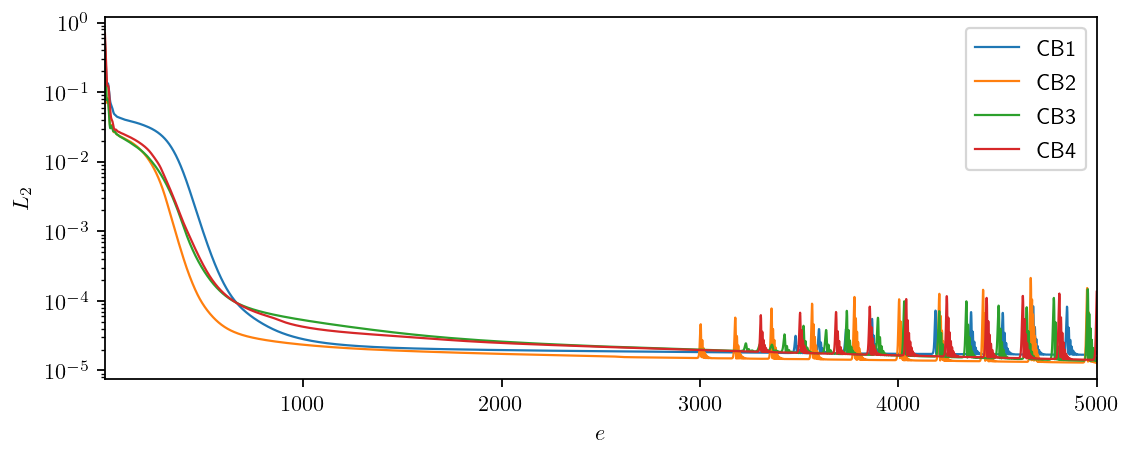

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for i, key in enumerate(all_losses.keys()):
    ax.plot(range(1, epochs+1), all_losses[key], ls="-", lw=1, label=key)
    
ax.set_xlabel("$e$")
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$")
ax.set_yscale('log')
ax.legend()
plt.show()

Text(0.5, 0, '$\\tilde{t}$')

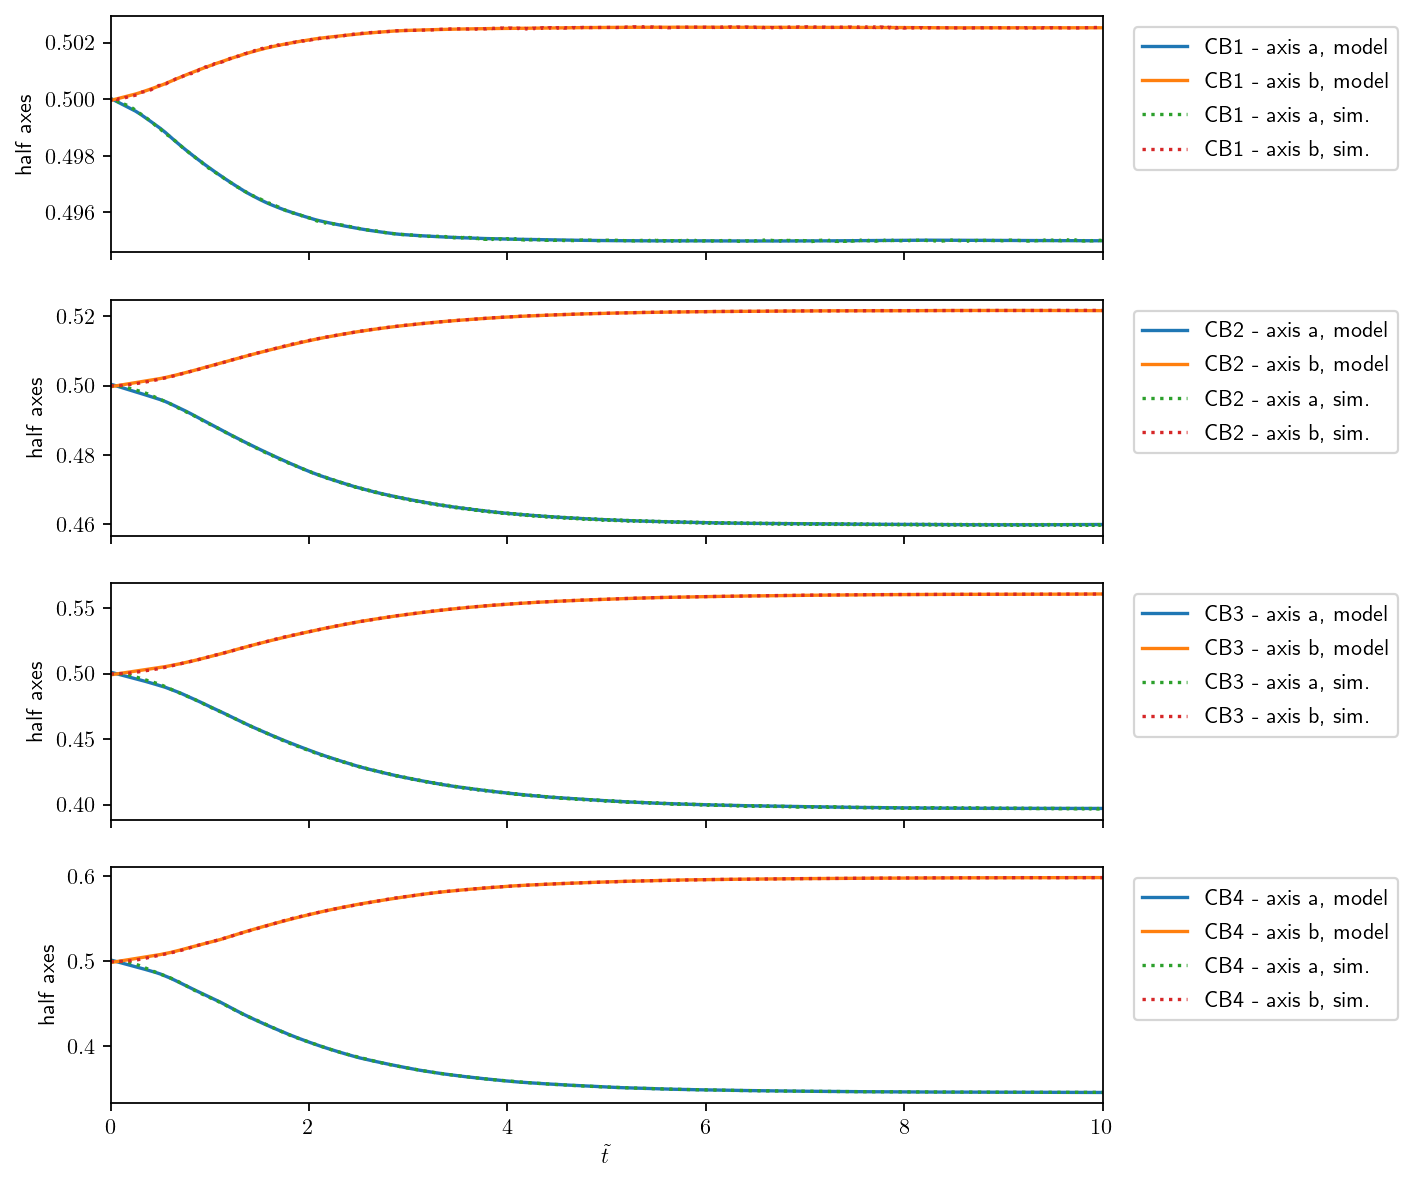

In [9]:
fig, axarr = plt.subplots(len(cases), 1, figsize=(8, 9), sharex=True)
time_plot = pt.linspace(0.0, 1.0, 200, dtype=pt.float64)

for i, case in enumerate(cases):
    model = SimpleMLP(**model_dict_ar)
    model_path = output_path + "/half_axes_{:s}.pt".format(case)
    model.load_state_dict(pt.load(model_path))
    axes_model = model(time_plot.unsqueeze(-1)).detach().numpy()
    rescaled = scalers_ar[case].inverse_transform(np.concatenate((np.expand_dims(time_plot, 1), axes_model), axis=1))
    axarr[i].plot(rescaled[:, 0], rescaled[:, 1], ls="-", label="{:s}, model".format(case + " - axis a"))
    axarr[i].plot(rescaled[:, 0], rescaled[:, 2], ls="-", label="{:s}, model".format(case + " - axis b"))
    axarr[i].plot(log_files[case].t.values, log_files[case].db_x.values/2.0, ls=":", label="{:s}, sim.".format(case + " - axis a"))
    axarr[i].plot(log_files[case].t.values, log_files[case].db_y.values/2.0, ls=":", label="{:s}, sim.".format(case + " - axis b"))
    axarr[i].set_xlim(0, 10)
    axarr[i].set_ylabel(r"half axes")
    axarr[i].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axarr[-1].set_xlabel(r"$\tilde{t}$")

In [10]:
class AxesModel(pt.nn.Module):
    def __init__(self, model_dict, model_path, scaler_ar):
        super(AxesModel, self).__init__()
        self._model = SimpleMLP(**model_dict)
        self._model.load_state_dict(pt.load(model_path))
        self._min_t = pt.tensor(scaler_ar.data_min_[0], dtype=pt.float64)
        self._range_t = pt.tensor(scaler_ar.data_range_[0], dtype=pt.float64)
        self._min_axes = pt.tensor(scaler_ar.data_min_[1:], dtype=pt.float64)
        self._range_axes = pt.tensor(scaler_ar.data_range_[1:], dtype=pt.float64)
        
    def _scale(self, X):
        return (X - self._min_t) / self._range_t
    
    def _inverse_scale(self, y):
        return y * self._range_axes + self._min_axes
    
    def forward(self, X):
        X = self._scale(X)
        return self._inverse_scale(self._model(X))

## Radius

In [11]:
interface_data = {}
for case in cases:
    file_path = output_path + case + "/interface_data_processed.pkl"
    interface_data[case] = pd.read_pickle(file_path)

In [12]:
def ellipsoidal_radius(time, theta, axes_model):
    """Compute the radius of an ellipse.
    
    Parameters
    ----------
    time - array-like: time, unscaled
    theta - array-like: polar angle
    axes_model - Module: model the predict the half-axes
    
    Returns
    -------
    radius - array-like: radius of ellipse; same shape as theta
    """
    axes = axes_model(pt.from_numpy(time).unsqueeze(-1)).detach().numpy()
    a = axes[:, 0]
    b = axes[:, 1]
    return a * b / np.sqrt(np.square(a * np.sin(theta)) + np.square(b * np.cos(theta)))

In [17]:
model_dict_rad = {
    "n_inputs" : 2,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : pt.nn.functional.selu,
    "batch_norm" : False
}

In [18]:
scalers_tt = {}
scalers_rad = {}
scaled_data_tt = {}
scaled_data_rad = {}

for case in cases:
    model_path = output_path + "/half_axes_{:s}.pt".format(case)
    model = AxesModel(model_dict_ar, model_path, scalers_ar[case])
    rad_ell = ellipsoidal_radius(interface_data[case].t.values, interface_data[case].theta.values, model)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(interface_data[case][["t", "theta"]].values)
    scalers_tt[case] = deepcopy(scaler)
    scaled_data_tt[case] = deepcopy(data)
    scaler = MinMaxScaler()
    rad_proj = interface_data[case].rad.values/rad_ell
    data = scaler.fit_transform(rad_proj[:, np.newaxis])
    scalers_rad[case] = deepcopy(scaler)
    scaled_data_rad[case] = deepcopy(data)

In [16]:
all_losses = {}

mask_int = np.zeros((interface_data["CB1"].shape[0]), dtype=bool)
mask_int[:1000] = True
mask_int[1000:20000:8] = True
mask_int[20000::16] = True
every = 10

epochs = 10000
for case in cases:
    model = SimpleMLP(**model_dict_rad)
    model_path = output_path + "/rad_{:s}.pt".format(case)
    features = scaled_data_tt[case][mask_int, :]
    rad = scaled_data_rad[case][mask_int]
    #features = scaled_data_tt[case]
    #rad = scaled_data_rad[case]
    _, losses = training_loop(model, model_path, features, rad, epochs, 0.001)
    all_losses[case] = losses

100%|██████████| 10000/10000 [08:48<00:00, 11.04it/s]


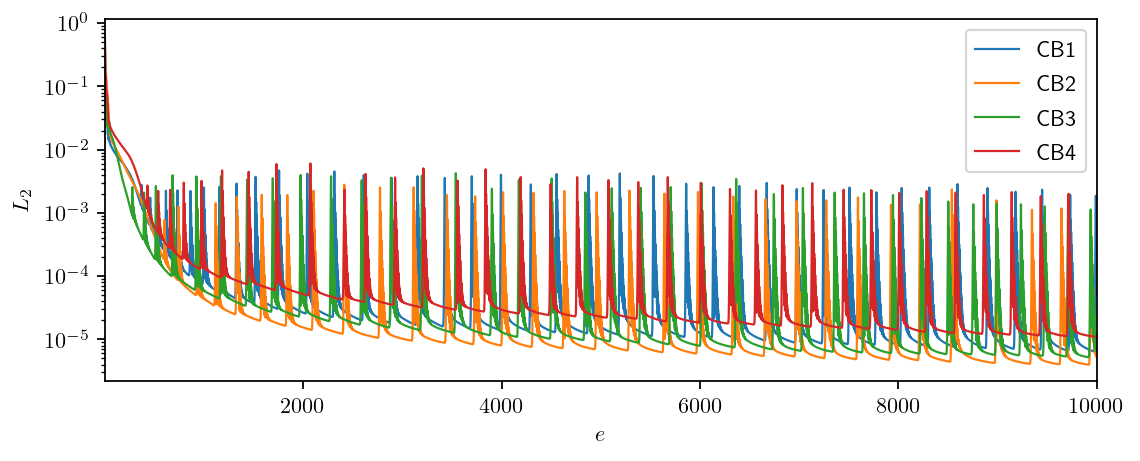

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for i, key in enumerate(all_losses.keys()):
    ax.plot(range(1, epochs+1), all_losses[key], ls="-", lw=1, label=key)
    
ax.set_xlabel("$e$")
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$")
ax.set_yscale('log')
ax.legend()
plt.show()

In [15]:
class RadiusModel(pt.nn.Module):
    def __init__(self, model_dict, model_path, axes_model, scaler_tt, scaler_rad):
        super(RadiusModel, self).__init__()
        self._model = SimpleMLP(**model_dict)
        self._model.load_state_dict(pt.load(model_path))
        self._axes_model = axes_model
        self._min_tt = pt.tensor(scaler_tt.data_min_, dtype=pt.float64)
        self._range_tt = pt.tensor(scaler_tt.data_range_, dtype=pt.float64)
        self._min_rad = pt.tensor(scaler_rad.data_min_, dtype=pt.float64)
        self._range_rad = pt.tensor(scaler_rad.data_range_, dtype=pt.float64)
        
    def _scale(self, X):
        return (X - self._min_tt) / self._range_tt
    
    def _inverse_scale(self, y):
        return y * self._range_rad + self._min_rad
    
    def _ellipsoidal_radius(self, X):
        axes = self._axes_model(X[:, 0].unsqueeze(-1))
        re = axes[:, 0] * axes[:, 1] / pt.sqrt(
            pt.square(axes[:, 0] * pt.sin(X[:, 1])) + pt.square(axes[:, 1] * pt.cos(X[:, 1]))
        )
        return re
    
    def forward(self, X):
        rad_ell = self._ellipsoidal_radius(X).squeeze()
        X = self._scale(X)
        X = self._inverse_scale(self._model(X)).squeeze()
        return X * rad_ell

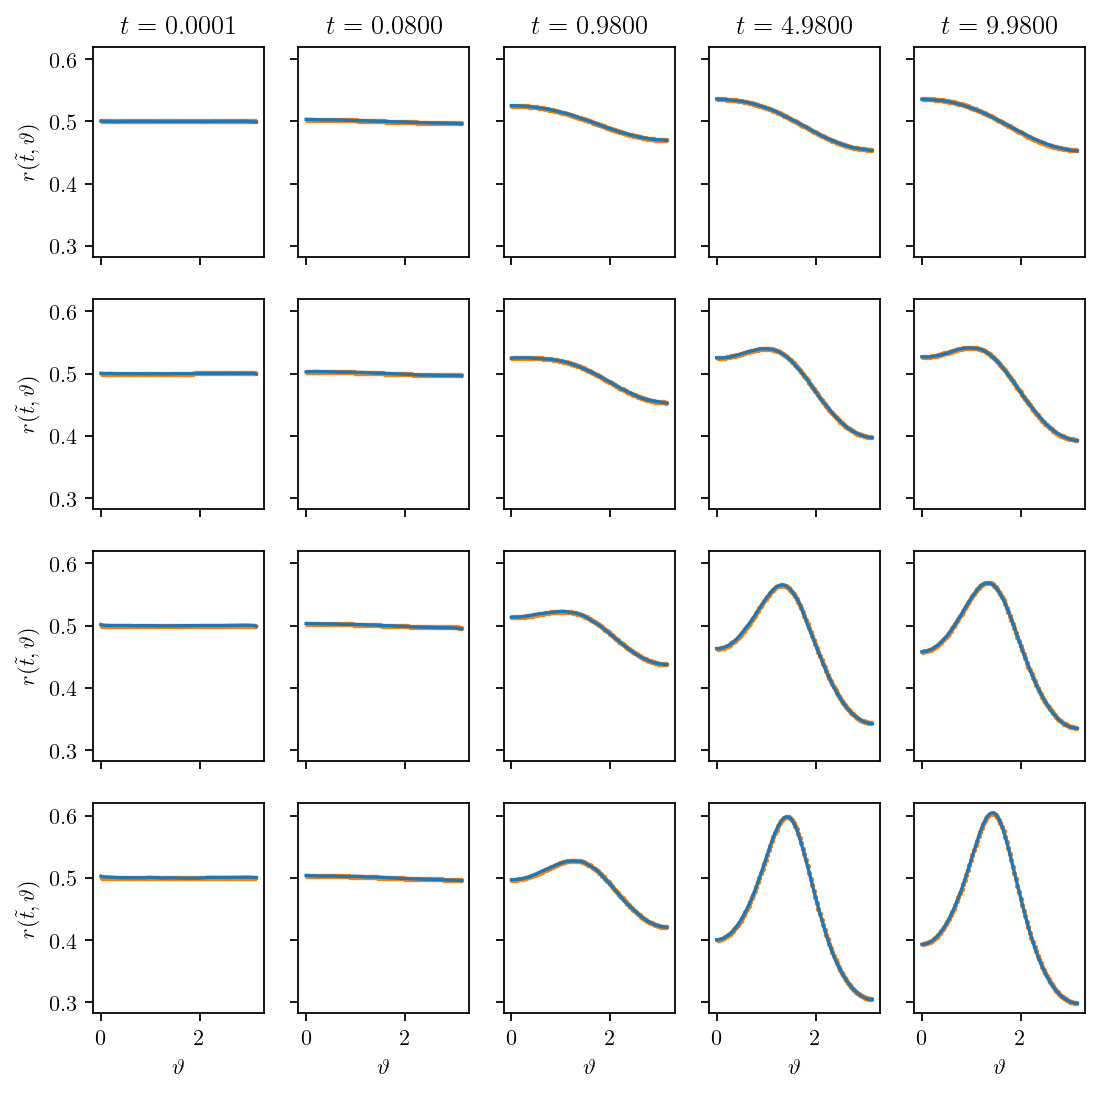

In [21]:
np_plot = 200
indices = np.array([0, 10, 100, 500, 1000])
times = interface_data[cases[0]].t.unique()[indices]
theta_plot = np.linspace(0.0, np.pi, np_plot)

fig, axarr = plt.subplots(len(cases), times.shape[0], figsize=(8, 8), sharex=True, sharey=True)

for i, case in enumerate(cases):
    model_path = output_path + "/half_axes_{:s}.pt".format(case)
    axes_model = AxesModel(model_dict_ar, model_path, scalers_ar[case])
    model_path = output_path + "/rad_{:s}.pt".format(case)
    model = RadiusModel(model_dict_rad, model_path, axes_model, scalers_tt[case], scalers_rad[case])
    for j, time in enumerate(times):
        time_plot = np.ones(np_plot) * time
        features = np.stack((time_plot, theta_plot)).T
        rad_model = model(pt.tensor(features)).detach().numpy()
        axarr[i, j].plot(theta_plot, rad_model, ls="-", label="{:s}, model".format(case))
        sim_data = interface_data[case][ interface_data[case].t == time ]
        axarr[i, j].scatter(sim_data.theta, sim_data.rad, s=2, c="C1", label="{:s}, sim.".format(case))
        if i == 0:
            axarr[i, j].set_title(r"$t={:2.4f}$".format(time))
        if i == len(cases) - 1:
            axarr[i, j].set_xlabel(r"$\vartheta$")
        if j == 0:
            axarr[i, j].set_ylabel(r"$r(\tilde{t},\vartheta)$")

## Tangential velocity

In [24]:
model_dict_tv = {
    "n_inputs" : 2,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : pt.nn.functional.selu,
    "batch_norm" : False
}

scalers_tv = {}
scaled_data_tv = {}

for case in cases:
    model_path_rv = output_path + "/rise_vel_{:s}.pt".format(case)
    model_rv = RiseVelocityModel(model_dict_rv, model_path_rv, scalers_rv[case])
    rv_model = model_rv(pt.from_numpy(interface_data[case].t.values).unsqueeze(-1)).detach().squeeze().numpy()
    scaler = MinMaxScaler()
    vt_trans = interface_data[case].vel_theta.values / rv_model
    data = scaler.fit_transform(vt_trans[:, np.newaxis])
    scalers_tv[case] = deepcopy(scaler)
    scaled_data_tv[case] = deepcopy(data)

In [21]:
all_losses = {}

mask_int = np.zeros((interface_data["CB1"].shape[0]), dtype=bool)
mask_int[:1000] = True
mask_int[1000:20000:6] = True
mask_int[20000::14] = True

epochs = 20000
for case in cases:
    model = SimpleMLP(**model_dict_tv)
    model_path = output_path + "/tv_{:s}.pt".format(case)
    features = scaled_data_tt[case][mask_int, :]
    tv = scaled_data_tv[case][mask_int]
    _, losses = training_loop(model, model_path, features, tv, epochs, 0.001)
    all_losses[case] = losses

100%|██████████| 20000/20000 [13:56<00:00, 24.31it/s]


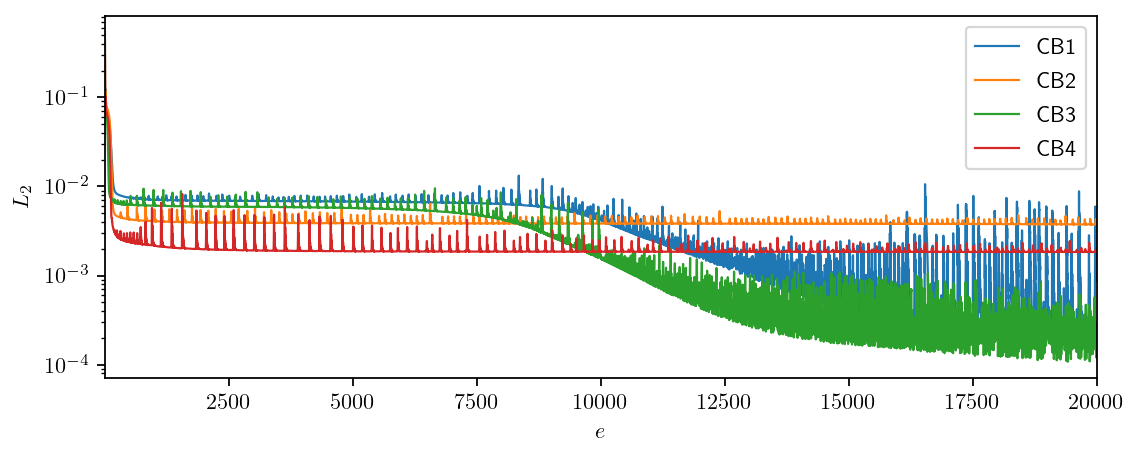

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for i, key in enumerate(all_losses.keys()):
    ax.plot(range(1, epochs+1), all_losses[key], ls="-", lw=1, label=key)
    
ax.set_xlabel("$e$")
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$")
ax.set_yscale('log')
ax.legend()
plt.show()

In [25]:
class TangentialVelocityModel(pt.nn.Module):
    def __init__(self, model_dict, model_path, rv_model, scaler_tt, scaler_tv):
        super(TangentialVelocityModel, self).__init__()
        self._model = SimpleMLP(**model_dict)
        self._model.load_state_dict(pt.load(model_path))
        self._rv_model = rv_model
        self._min_tt = pt.tensor(scaler_tt.data_min_, dtype=pt.float64)
        self._range_tt = pt.tensor(scaler_tt.data_range_, dtype=pt.float64)
        self._min_tv = pt.tensor(scaler_tv.data_min_, dtype=pt.float64)
        self._range_tv = pt.tensor(scaler_tv.data_range_, dtype=pt.float64)
        
    def _scale(self, X):
        return (X - self._min_tt) / self._range_tt
    
    def _inverse_scale(self, y):
        return y * self._range_tv + self._min_tv
    
    def _rise_velocity(self, X):
        return self._rv_model(X[:, 0].unsqueeze(-1))
    
    def forward(self, X):
        rv = self._rise_velocity(X).squeeze()
        X = self._scale(X)
        X = self._inverse_scale(self._model(X)).squeeze()
        return X * rv

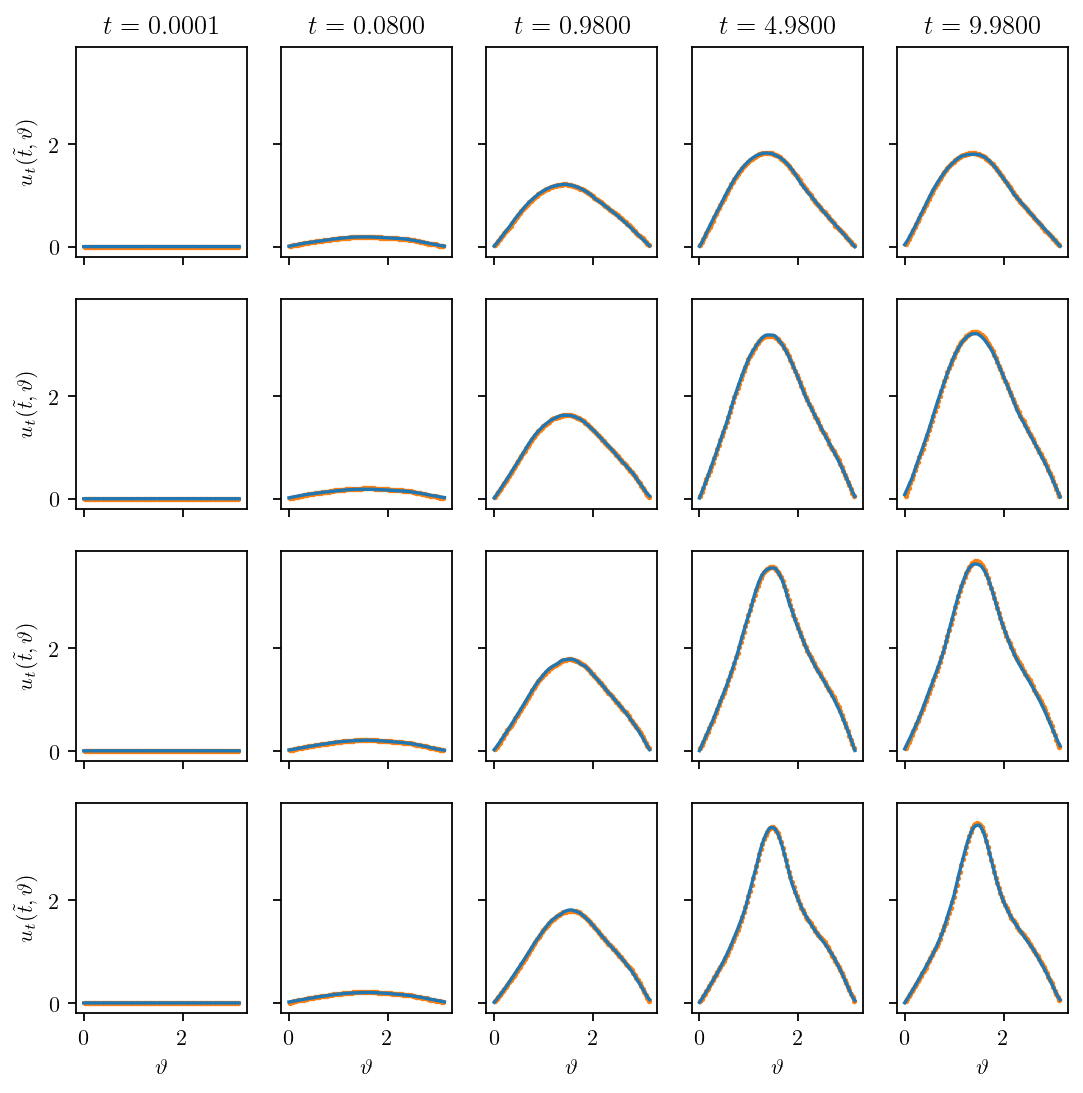

In [26]:
np_plot = 200
indices = np.array([0, 10, 100, 500, 1000])
times = interface_data[cases[0]].t.unique()[indices]
theta_plot = np.linspace(0.0, np.pi, np_plot)

fig, axarr = plt.subplots(len(cases), times.shape[0], figsize=(8, 8), sharex=True, sharey=True)

for i, case in enumerate(cases):
    model_path = output_path + "/rise_vel_{:s}.pt".format(case)
    model_rv = RiseVelocityModel(model_dict_rv, model_path, scalers_rv[case])
    model_path = output_path + "/tv_{:s}.pt".format(case)
    model = TangentialVelocityModel(model_dict_tv, model_path, model_rv, scalers_tt[case], scalers_tv[case])
    
    for j, time in enumerate(times):
        time_plot = np.ones(np_plot) * time
        features = np.stack((time_plot, theta_plot)).T
        tv_model = model(pt.tensor(features)).detach().numpy()
        axarr[i, j].plot(theta_plot, tv_model, ls="-", label="{:s}, model".format(case))
        sim_data = interface_data[case][ interface_data[case].t == time ]
        axarr[i, j].scatter(sim_data.theta, sim_data.vel_theta.values, s=2, c="C1", label="{:s}, sim.".format(case))
        if i == 0:
            axarr[i, j].set_title(r"$t={:2.4f}$".format(time))
        if i == len(cases) - 1:
            axarr[i, j].set_xlabel(r"$\vartheta$")
        if j == 0:
            axarr[i, j].set_ylabel(r"$u_t(\tilde{t},\vartheta)$")

## Exporting the models

For some miraculous reason, this export (the tracing) only works for a single model every time the kernel is restarted. Otherwise, the models are exported but they cause a memory leak when loaded in the C++ frontend (the exported models work in Python though). This effect might be caused by a difference in the library version (1.6 in the OpenFOAM/PyTorch container and 1.5 in the Jupyter/Python container).

In [15]:
#def trace_and_save(model, example, path):
#    traced_model = pt.jit.trace(model.eval(), example)
#    traced_model.save(path)

In [16]:
#for case in cases[3:]:
#    print(case)
#    model_path = output_path + "/rise_vel_{:s}.pt".format(case)
#    model_rv = RiseVelocityModel(model_dict_rv, model_path, scalers_rv[case])
#    trace_and_save(model_rv, pt.ones((1,1)), output_path + "rise_vel_{:s}.ts".format(case))
#    model_path = output_path + "/tv_{:s}.pt".format(case)
#    model_tv = TangentialVelocityModel(model_dict_tv, model_path, model_rv, scalers_tt[case], scalers_tv[case])
#    trace_and_save(model_tv, pt.ones((1,2)), output_path + "tv_{:s}.ts".format(case))
#    model_path = output_path + "/half_axes_{:s}.pt".format(case)
#    model_axes = AxesModel(model_dict_ar, model_path, scalers_ar[case])
#    model_path = output_path + "/rad_{:s}.pt".format(case)
#    model_rad = RadiusModel(model_dict_rad, model_path, model_axes, scalers_tt[case], scalers_rad[case])
#    trace_and_save(model_rad, pt.ones((1,2)), output_path + "rad_{:s}.ts".format(case))
    #del model_rv, model_tv, model_axes, model_rad

CB4
